In [1]:
#import uproot4 as uproot
improt uproot
import boost_histogram as bh
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplhep as hep
import awkward1 as ak
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
def set_sns_color(*args):
    sns.palplot(sns.color_palette(*args))
    sns.set_palette(*args)
    
color_order_bkg = sns.color_palette('Accent', 3)
color_order_bkg.reverse()

In [3]:
use_helvet = True  ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

In [4]:
import sys,os

In [5]:
sys.path.append("/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/lib")

In [6]:
from utils import *

In [7]:
#find root files in this dir
def find_this_rootfiles(dir):
    filename_list = os.listdir(dir)
    files = []
    for i, filename in enumerate(filename_list):
        if(filename.find(".root")==-1): continue
        files.append(filename)
    return files

#create histo from ak.Array
def get_hist(array,weights,nbins=50,xmin=None, xmax=None,mergeflowbin=True):
    if xmin is None:
        xmin = ak.min(array)
    if xmax is None:
        xmax = ak.max(array)
    bins  = bh.axis.Regular(nbins, xmin, xmax)
    hist = bh.Histogram(bins,storage=bh.storage.Weight())
    hist.fill(array,weight=weights)
    return hist

#get err from histo
def get_err(hist):
    err =  np.sqrt(hist.view(flow=False).variance)
    #err =  hist.view(flow=False).variance
    return err

#if an array has np.nan meberdata, replace it 
def replace_nan(arr,isunc):
    if isunc == False:
        arr[np.isnan(arr)]=-1
    elif isunc == True:
        arr[np.isnan(arr)]=0
        
    return arr

#plot hist using mplhep
def plot_hist(hists, normed=False, **kwargs):
    r"""Plot the histogram in the type of boost_histogram
    """
    
    if not isinstance(hists, (list, tuple)):
        hists = [hists]
    content = [h.view(flow=False).value for h in hists]
    bins = hists[0].axes[0].edges
    if 'bins' in kwargs:
        bins = kwargs.pop('bins')
    if 'yerr' in kwargs:
        yerr = kwargs.pop('yerr')
    else:
        yerr = [np.sqrt(h.view(flow=False).variance) for h in hists]
    if normed:
        for i in range(len(content)):
            contsum = sum(content[i])
            content[i] /= contsum
            yerr[i] /= contsum
    if len(hists) == 1:
        content, yerr = content[0], yerr[0]
    hep.histplot(content, bins=bins, yerr=yerr, **kwargs)

In [8]:
ori_dir = '/cms/user/guojl/Sample/2L2Q/UL_Legacy/2016/'
samples_inf = {#name path cross Section
                    #'DY_pt50To100':['MC/DYJetsToLL_Pt-50To100_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8', 363.8142],
                    'DY_pt50To100':['MC/DYJetsToLL_Pt-50To100_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8', 398.8],
                    #'DY_pt100To250':['MC/DYJetsToLL_Pt-100To250_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8',84.014804],
                    'DY_pt100To250':['MC/DYJetsToLL_Pt-100To250_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8',93.61],
                    'DY_pt250To400':['MC/DYJetsToLL_Pt-250To400_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8',3.67],#3.047],
                    'DY_pt400To650':['MC/DYJetsToLL_Pt-400To650_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8',0.5],#0.392],
                    'DY_pt650ToInf':['MC/DYJetsToLL_Pt-650ToInf_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8',0.04704],#0.03636],
                    'TTJets':['MC/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8',831.76],
                    'TTTo2L2Nu':['MC/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8',1],
                    'WW_TuneCP5':['MC/WW_TuneCP5_13TeV-pythia8',1],
                    'WWTo2L2Nu':['MC/WWTo2L2Nu_TuneCP5_13TeV-powheg-pythia8',11.09],
                    'WZTo2Q2L':['MC/WZTo2Q2L_mllmin4p0_TuneCP5_13TeV-amcatnloFXFX-pythia8',6.419],
                    'ZZTo2Q2L':['MC/ZZTo2Q2L_mllmin4p0_TuneCP5_13TeV-amcatnloFXFX-pythia8',3.696],
                    'ggH1000':['MC/Signal/skimed/GluGluHToZZTo2L2Q_M1000_TuneCP5_13TeV_powheg2_JHUGenV7011_pythia8__asymptotic_v17-v2_0.root',5.07],
                    'VBF1500':['MC/Signal/skimed/VBF_HToZZTo2L2Q_M1500_TuneCP5_13TeV_powheg2_JHUGenV7011_pythia8__asymptotic_v13-v1_0.root',0.77],
                    'test':'MC/test',
                    'Data':['Data/skimed/Data2016UL_noDuplicates.root',1],
                    }

Samples_lists = ['DY_pt50To100','DY_pt100To250','DY_pt250To400','DY_pt400To650','DY_pt650ToInf',
              'TTJets',
              'WZTo2Q2L',
              'ZZTo2Q2L',
              'WWTo2L2Nu',
              'Data']

signal_lists = [ 'ggH1000','VBF1500']

lumi = {2016: 16.81, 2017: 41.53, 2018: 59.74}
year=2016

bininfo = {'mass2l':[24,60,120,"M(ll)"],
              'pt2l':[70,100,800,"Pt(ll)"],
              #'massmerged':[28,40,180,"M(J)"],
              'massmerged':[40,0,200,"M(J)"],
              'ptmerged':[60,200,800,"Pt(J)"],
              'mass2l2jet':[28,40,180,"M(2l2q)"], 
              'pt2jet':[70,100,800,"Pt(jj)"],
              'mass2jet':[28,40,180,"M(jj)"],
              'particleNetZvsQCD':[20,0,1,"particleNetZvsQCD"],
              'KD_jjVBF':[20,0,1,"VBF(score)"]}

cats = ['isEE','isMuMu']

In [16]:
#var to read
var_read_lists = ['pt2l','mass2l','EventWeight','foundZ1LCandidate','foundTTCRCandidate','foundZ2JCandidate','foundZ2MergedCandidata','foundTTCRCandidate','passedfullmerged','passedfullresolved','particleNetZvsQCD','passedNassociated','isEE','isMuMu',
                        'massmerged','ptmerged',
                        'pt2jet','mass2jet',
                        'mass2l2jet', 'mass2lj',
                        'KD_jjVBF',
                         'isbjet','iscjet','islightjet']
#var to draw
#var = 'mass2l'
#nbins, xmin, xmax = bininfo[var][0], bininfo[var][1], bininfo[var][2]

#bins  = bh.axis.Regular(nbins, xmin, xmax)
#hist_DY = bh.Histogram(bins,storage=bh.storage.Weight())
#hist_TTjst = bh.Histogram(bins,storage=bh.storage.Weight())
#hist_VZ = bh.Histogram(bins,storage=bh.storage.Weight())

In [17]:
#extract branch for each sample
bkg_array = {}
data_array = None
signal_array = {}
sumWeight = {}

for sample in Samples_lists:
    print(f"This is {sample}")
    if sample!='Data':
        indir = ori_dir+samples_inf[sample][0]+'/skimed'
        files = find_this_rootfiles(indir)
        sumWeight[sample] = 0
            
        for file in files:
            with uproot.open(f'{indir}/{file}') as f:
                this_sumWeight_h = f['sumWeights'].to_boost()
                this_sumWeight = this_sumWeight_h.sum()
                #print(f'this sum weight = {this_sumWeight}')
                sumWeight[sample] += this_sumWeight
                    
        bkg_array[sample] = uproot.lazy([f"{indir}/*.root:passedEvents"],filter_name=var_read_lists)
        
    else:
        data_path = ori_dir+samples_inf['Data'][0]
        data_array = uproot.lazy([f"{data_path}:passedEvents"],filter_name=var_read_lists)

for sample in signal_lists:
    print(f"This is {sample}")
    signal_path = ori_dir+samples_inf[sample][0]
    
    sumWeight[sample] = 0
    with uproot.open(signal_path) as f:
        this_sumWeight_h = f['sumWeights'].to_boost()
        this_sumWeight = this_sumWeight_h.sum()
        sumWeight[sample] += this_sumWeight
        
        signal_array[sample] = f['passedEvents'].arrays(filter_name=var_read_lists,library="ak")
        

This is DY_pt50To100
This is DY_pt100To250
This is DY_pt250To400
This is DY_pt400To650
This is DY_pt650ToInf
This is TTJets
This is WZTo2Q2L
This is ZZTo2Q2L
This is WWTo2L2Nu
This is Data
This is ggH1000
This is VBF1500


In [11]:
def make_cut(array,cat): 
    cut_array = array[cat] & array['foundZ1LCandidate'] & array['foundZ2MergedCandidata'] & ((array['massmerged']<70) | (array['massmerged']>105)) & (array['particleNetZvsQCD']>0.9)
    #cut_array = array[cat] & array['foundZ2JCandidate'] & ((array['mass2jet']<70) | (array['mass2jet']>105)) & array['passedNassociated']#resovled
    #cut_array = array[cat] #leptonic Z
    return cut_array

In [18]:
#apply cut and for each sample
bkg_array_cut = {}; data_array_cut = {}; signal_array_cut = {}
for cat in cats:
    bkg_array_cut[cat] = {}; data_array_cut[cat] = None; signal_array_cut[cat] = {}
    for sample in Samples_lists:
        #print(f"This is {sample} in {cat}")
        if sample!='Data':
            temp_array = bkg_array[sample]
            cut_array = make_cut(temp_array,cat)
            bkg_array_cut[cat][sample] = temp_array[cut_array]
        else:
            temp_array = data_array
            
            cut_array = make_cut(temp_array,cat)
            data_array_cut[cat] = temp_array[cut_array]
    for sample in signal_lists:
        temp_array = signal_array[sample]
        cut_array = make_cut(temp_array,cat)
        signal_array_cut[cat][sample] = temp_array[cut_array]

In [23]:
def GetParticleNetSignalSF(array,tagger):
    if tagger=='ZvsQCD':
        tag = 'particleNetZvsQCD'
    elif tagger=='btag':
        tag = 'particleNetZbbvslight'
    else:
        print("[ERROR] Please enter correctly tagger(only ZvQCD and btag are available )")
        sys.exit()
        
    sf_arr = ak.zeros_like(array['particleNetZvsQCD'])
    sf_arr = ak.to_numpy(sf_arr)
    
    wsp = {"LP":[0.90,0.94],'MP':[0.94,0.98],'HP':[0.98,1.0]}
    flavors = {'bhadron':'isbjet','chadron':'iscjet','lighthadron':'islightjet'}
    pt_ranges = {'200To400':[200,400],'400To600':[400,600],'600ToInf':[600,9999999]} 
    
    for pur in wsp.keys():
        for flavor in flavors.keys():
            for pt_range in pt_ranges.keys():
                cut = "({}>{}) & ({}<={}) & (ptmerged>={}) & (ptmerged<{}) & ({}==True)".format(tag,wsp[pur][0],tag,wsp[pur][1],pt_ranges[pt_range][0],pt_ranges[pt_range][1],flavors[flavor])
                cut_arr = ak.numexpr.evaluate(cut,array)
                sf_arr[cut_arr] = float(sf_particleNet_signal[tagger][flavor][pur][pt_range])
    sf_arr = ak.from_numpy(sf_arr)
    print("This sf_array = ",sf_arr)
    return sf_arr


def GetParticleNetbkgSF(array,tagger,cat):
    if tagger=='ZvsQCD':
        if cat == 'DY':
            sf_arr = ak.full_like(array['particleNetZvsQCD'],1.36)
        elif cat == 'TT':
            sf_arr = ak.full_like(array['particleNetZvsQCD'],0.83)
        else:
            print("[ERROR] Please enter correctly CR cat (only DY and TT are available )")
            sys.exit()
    elif tagger=='btag':
        print("[ERROR] btag SF will come soon )")
        sys.exit()
        """if cat == 'DY':
            sf_arr = ak.full_like(array['particleNetZvsQCD'],1.36)
        elif cat == 'TT':
            sf_arr = ak.full_like(array['particleNetZvsQCD'],0.83)
        else:
            print("[ERROR] Please enter correctly CR cat (only DY and TT are available )")
            sys.exit()"""
    else:
        print("[ERROR] Please enter correctly tagger(only ZvQCD and btag are available )")
        sys.exit()
        
    return sf_arr
        

In [20]:
import yaml

In [21]:
sf_particleNet_signal = {}
with open('/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/cards/NetSF_signal_2016Legacy.yml') as f:
    sf_particleNet_signal = yaml.safe_load(f)

This is DY_pt50To100 in isEE
This is DY_pt100To250 in isEE
This is DY_pt250To400 in isEE
This is DY_pt400To650 in isEE
This is DY_pt650ToInf in isEE
This is TTJets in isEE
This is WZTo2Q2L in isEE
This sf_array =  [0.881, 0.975, 1.04, 0.842, 0.975, 0.842, ... 0.881, 1.11, 0.887, 0.975, 0.881]
This is ZZTo2Q2L in isEE
This sf_array =  [0.89, 1.04, 0.975, 0.842, 1.21, 1.04, ... 0.985, 0.738, 0.756, 0.918, 0.918, 0.89]
This is WWTo2L2Nu in isEE
This is Data in isEE
data weight  = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
This sf_array =  [0.929, 0.89, 1.11, 1.08, 0.985, 0.756, ... 1.21, 0.929, 1.08, 0.97, 1.04, 0.918]
This sf_array =  [1.07, 0.738, 1.04, 1.11, 0.97, 1.04, 0.887, ... 1.1, 1.08, 1.09, 1.1, 1.04, 1.34]
This is DY_pt50To100 in isMuMu
This is DY_pt100To250 in isMuMu
This is DY_pt250To400 in isMuMu
This is DY_pt400To650 in isMuMu
This is DY_pt650ToInf in isMuMu
This is TTJets in isMuMu
This is WZTo2Q2L in isMuMu
This sf_array =  [0.84

/tmp/ipykernel_31739/3972698734.py:113: RuntimeWarning: invalid value encountered in true_divide
  ratio=np.nan_to_num((data/bkg_tot),nan=-1)
/tmp/ipykernel_31739/3972698734.py:114: RuntimeWarning: invalid value encountered in true_divide
  ratio_err = np.nan_to_num((data_err/bkg_tot),nan=-1)
/tmp/ipykernel_31739/3972698734.py:118: RuntimeWarning: invalid value encountered in true_divide
  ratio_unc_low = np.nan_to_num(((bkg_tot-bkg_err)/bkg_tot),nan=-1)
/tmp/ipykernel_31739/3972698734.py:119: RuntimeWarning: invalid value encountered in true_divide
  ratio_unc_up = np.nan_to_num(((bkg_tot+bkg_err)/bkg_tot),nan=-1)


[INFO] it is isMuMu plot


/tmp/ipykernel_31739/3972698734.py:113: RuntimeWarning: invalid value encountered in true_divide
  ratio=np.nan_to_num((data/bkg_tot),nan=-1)
/tmp/ipykernel_31739/3972698734.py:114: RuntimeWarning: invalid value encountered in true_divide
  ratio_err = np.nan_to_num((data_err/bkg_tot),nan=-1)
/tmp/ipykernel_31739/3972698734.py:118: RuntimeWarning: invalid value encountered in true_divide
  ratio_unc_low = np.nan_to_num(((bkg_tot-bkg_err)/bkg_tot),nan=-1)
/tmp/ipykernel_31739/3972698734.py:119: RuntimeWarning: invalid value encountered in true_divide
  ratio_unc_up = np.nan_to_num(((bkg_tot+bkg_err)/bkg_tot),nan=-1)


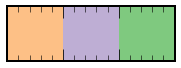

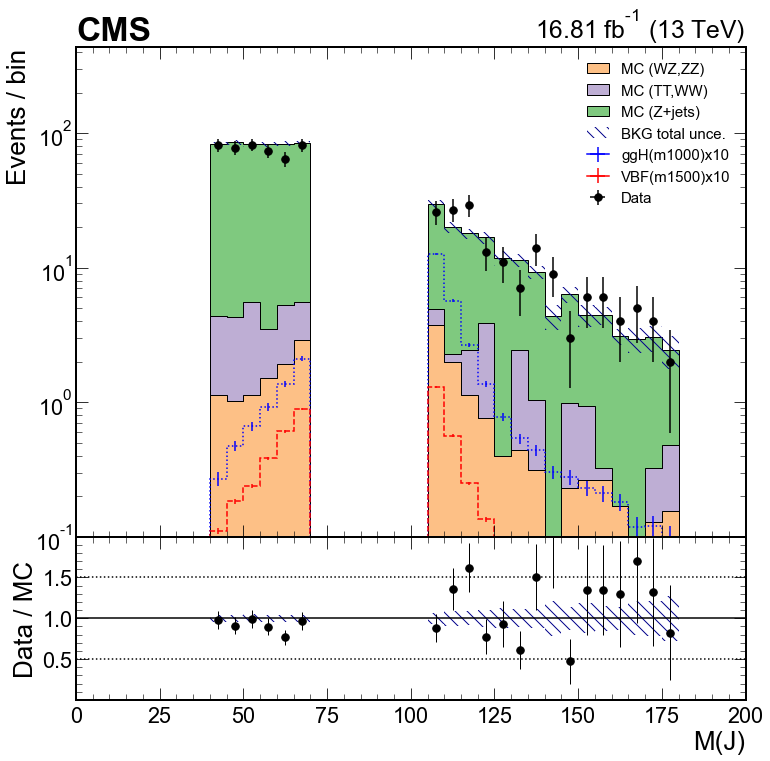

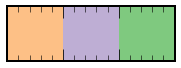

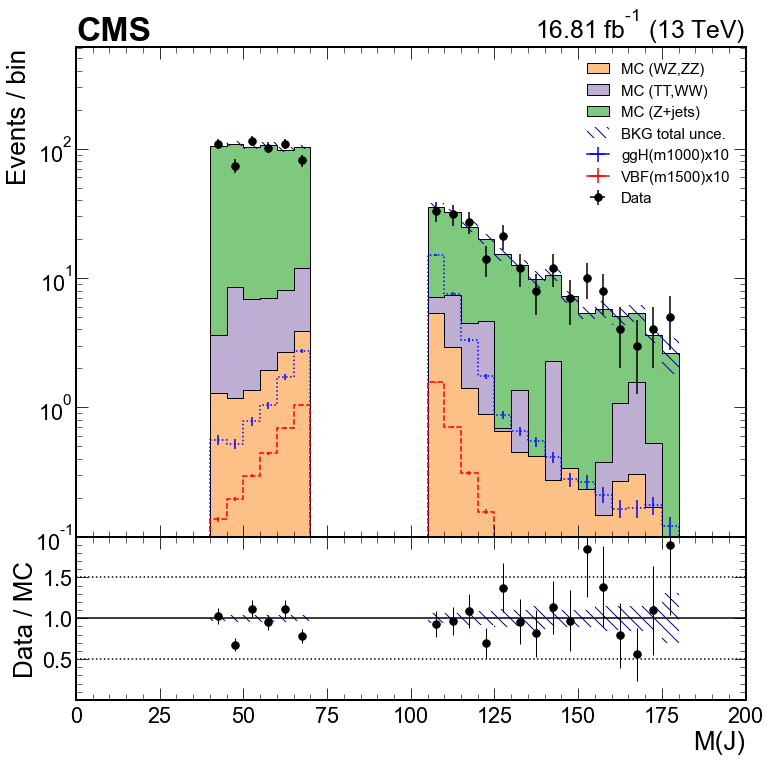

In [25]:
####======================================draw single var============================================
#set draw var
var = 'massmerged'
nbins, xmin, xmax = bininfo[var][0], bininfo[var][1], bininfo[var][2]
edge = np.linspace(xmin, xmax, nbins+1)
if var.find('pt')!=-1 or var.find('massmerged')!=-1 or var.find('mass2jet')!=-1:
    islogY = True
else:
    islogY = True
        
#fill histo 
bkg_hists = {}; Data_hist = {}; signal_hists = {}
for cat in cats:
    bkg_hists[cat] = [None,None,None]; Data_hist[cat] = None; signal_hists[cat] = []
    for sample in Samples_lists:
        print(f"This is {sample} in {cat}")
        if sample!='Data':
            temp_array = bkg_array_cut[cat][sample]
            #retray weight and apply paritcleNet weight
            weights = (temp_array['EventWeight']*lumi[2016]*1000*samples_inf[sample][1])/sumWeight[sample]
            if sample == 'ZZTo2Q2L' or sample =='WZTo2Q2L':
                sf_Net = GetParticleNetSignalSF(temp_array,'ZvsQCD')
            elif sample.find('DY')!=-1:
                sf_Net = GetParticleNetbkgSF(temp_array,'ZvsQCD','DY')
            elif sample.find('TTJets')!=-1 or sample.find('WWTo2L2Nu')!=-1:
                sf_Net = GetParticleNetbkgSF(temp_array,'ZvsQCD','TT')
            else:
                sf_Net = ak.ones_like(temp_array['EventWeight'])
            weights = weights*sf_Net
                
            temp_hist = get_hist(temp_array[var],weights,nbins,xmin,xmax)
            
            if sample.find('DY')!=-1:
                if (bkg_hists[cat])[2]==None:
                    (bkg_hists[cat])[2] = temp_hist
                else:
                    (bkg_hists[cat])[2]+=temp_hist
            if sample.find('TTJets')!=-1 or sample.find('WWTo2L2Nu')!=-1:
                if (bkg_hists[cat])[1]==None:
                    (bkg_hists[cat])[1] = temp_hist
                else:
                    (bkg_hists[cat])[1]+=temp_hist
            if sample.find('WZTo2Q2L')!=-1 or sample.find('ZZTo2Q2L')!=-1:
                if (bkg_hists[cat])[0]==None:
                    (bkg_hists[cat])[0] = temp_hist
                else:
                    (bkg_hists[cat])[0]+=temp_hist
        else:
            temp_array = data_array_cut[cat]
            weights = np.ones_like(temp_array['EventWeight'])
            print(f'data weight  = {weights}')
            Data_hist[cat] = get_hist(temp_array[var],weights,nbins,xmin,xmax)
        
    for sample in signal_lists:
        temp_array = signal_array_cut[cat][sample]
        weights = (temp_array['EventWeight']*lumi[2016]*samples_inf[sample][1]*10)/sumWeight[sample] #scale 10
        sf_Net = GetParticleNetSignalSF(temp_array,tagger='ZvsQCD')
        weights = weights*sf_Net
        temp_hist = get_hist(temp_array[var],weights,nbins,xmin,xmax)
        signal_hists[cat].append(temp_hist)
    
print("Fill done")

#draw var
for cat in cats:
    print(f"[INFO] it is {cat} plot")
    plot_unce = True
    set_sns_color(color_order_bkg)
    f = plt.figure(figsize=(12,12))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0)
    ##================================ Upper histogram panel=========================================
    ax = f.add_subplot(gs[0])
    hep.cms.label(data=True, year=year, ax=ax, rlabel=r'%s $fb^{-1}$ (13 TeV)'%lumi[year], fontname='sans-serif')
    ax.set_xlim(xmin, xmax); ax.set_xticklabels([]); ax.set_ylabel('Events / bin', ha='right', y=1.0)
    
    ##BACKGRUND
    #hep.histplot(bkg_hists[cat],label=[f'MC ({var})' for var in ['WZ,ZZ','TT,WW','Z+jets']],histtype='fill', edgecolor='k', linewidth=1, stack=True) ## draw MC
    plot_hist(bkg_hists[cat],label=[f'MC ({var})' for var in ['WZ,ZZ','TT,WW','Z+jets']],histtype='fill', edgecolor='k', linewidth=1, stack=True) ## draw MC
    bkg_hist = bkg_hists[cat][0]+bkg_hists[cat][1]+bkg_hists[cat][2]
    bkg_tot = bkg_hist.values()
    bkg_err = get_err(bkg_hist)
    #bkg_err = np.sqrt(bkg_hist.view(flow=False).variance)

    if plot_unce:
        #ax.fill_between(edge, (bkg_tot-bkg_err).tolist()+[0], (bkg_tot+bkg_err).tolist()+[0], label='BKG total unce.', step='post', hatch='\\\\', edgecolor='dimgrey', facecolor='none', linewidth=0) ## draw bkg unce. 
        ax.fill_between(edge, (bkg_tot-bkg_err).tolist()+[0], (bkg_tot+bkg_err).tolist()+[0], label='BKG total unce.', step='post', hatch='\\\\', edgecolor='darkblue', facecolor='none', linewidth=0) ## draw bkg unce.
    ax.set_xlim(xmin, xmax); ax.set_xticklabels([]);
    ax.set_ylabel('Events / bin', ha='right', y=1.0);
    
    ##SIGNAL
    colors = ['blue', 'red']
    plot_hist(signal_hists[cat],label=[ var for var in ['ggH(m1000)x10','VBF(m1500)x10']],linestyle=[style for style in [':','--']], color=[color for color in colors])
    
    ##DATA
    data_err = get_err(Data_hist[cat])
    data = Data_hist[cat].values()
    #hep.histplot(Data_hist[cat], yerr=data_err,label='Data', histtype='errorbar', color='k', markersize=15, elinewidth=1.5) ## draw data
    plot_hist(Data_hist[cat],label='Data', histtype='errorbar', color='k', markersize=15, elinewidth=1.5) ## draw data
    if islogY:
        ax.set(yscale = "log")
        ax.set_ylim(1e-1, 3*ax.get_ylim()[1])
    else:
        ax.set_ylim(0, ax.get_ylim()[1])
        ax.set_ylim(0, 1.5*max(data))
    hep.plot.yscale_legend
    ax.legend(fontsize=15)

    ##==========================================Ratio panel========================
    ax1 = f.add_subplot(gs[1]); ax1.set_xlim(xmin, xmax); ax1.set_ylim(0.001, 1.999)
    ax1.set_xlabel(bininfo[var][3], ha='right', x=1.0); ax1.set_ylabel('Data / MC', ha='center')
    ax1.plot([xmin,xmax], [1,1], 'k'); ax1.plot([xmin,xmax], [0.5,0.5], 'k:'); ax1.plot([xmin,xmax], [1.5,1.5], 'k:')
    
    ratio=np.nan_to_num((data/bkg_tot),nan=-1)
    ratio_err = np.nan_to_num((data_err/bkg_tot),nan=-1)
    hep.histplot(ratio, yerr = ratio_err,bins=edge, histtype='errorbar', color='k', markersize=15, elinewidth=1)
    #hep.histplot(data/bkg_tot, yerr = data_err/bkg_err,bins=edge, histtype='errorbar', color='k', markersize=15, elinewidth=1)
    if plot_unce:
        ratio_unc_low = np.nan_to_num(((bkg_tot-bkg_err)/bkg_tot),nan=-1)
        ratio_unc_up = np.nan_to_num(((bkg_tot+bkg_err)/bkg_tot),nan=-1)
        ax1.fill_between(edge, ratio_unc_low.tolist()+[0],ratio_unc_up.tolist()+[0], step='post', hatch='\\\\', edgecolor='darkblue', facecolor='none', linewidth=0) ## draw bkg unce.
        #ax1.fill_between(edge, ((bkg_tot-bkg_err)/bkg_tot).tolist()+[0], ((bkg_tot+bkg_err)/bkg_tot).tolist()+[0], step='post', hatch='\\\\', edgecolor='darkblue', facecolor='none', linewidth=0) ## draw bkg unce.

[INFO] it is mass2jet plot
Fill done mass2jet
[INFO] it is isEE plot


/tmp/ipykernel_16115/1468490722.py:103: RuntimeWarning: invalid value encountered in true_divide
  ratio=np.nan_to_num((data/bkg_tot),nan=-1)
/tmp/ipykernel_16115/1468490722.py:104: RuntimeWarning: invalid value encountered in true_divide
  ratio_err = np.nan_to_num((data_err/bkg_tot),nan=-1)
/tmp/ipykernel_16115/1468490722.py:108: RuntimeWarning: invalid value encountered in true_divide
  ratio_unc_low = np.nan_to_num(((bkg_tot-bkg_err)/bkg_tot),nan=-1)
/tmp/ipykernel_16115/1468490722.py:109: RuntimeWarning: invalid value encountered in true_divide
  ratio_unc_up = np.nan_to_num(((bkg_tot+bkg_err)/bkg_tot),nan=-1)


[INFO] it is isMuMu plot
[INFO] it is pt2jet plot


/tmp/ipykernel_16115/1468490722.py:103: RuntimeWarning: invalid value encountered in true_divide
  ratio=np.nan_to_num((data/bkg_tot),nan=-1)
/tmp/ipykernel_16115/1468490722.py:104: RuntimeWarning: invalid value encountered in true_divide
  ratio_err = np.nan_to_num((data_err/bkg_tot),nan=-1)
/tmp/ipykernel_16115/1468490722.py:108: RuntimeWarning: invalid value encountered in true_divide
  ratio_unc_low = np.nan_to_num(((bkg_tot-bkg_err)/bkg_tot),nan=-1)
/tmp/ipykernel_16115/1468490722.py:109: RuntimeWarning: invalid value encountered in true_divide
  ratio_unc_up = np.nan_to_num(((bkg_tot+bkg_err)/bkg_tot),nan=-1)


Fill done pt2jet
[INFO] it is isEE plot
[INFO] it is isMuMu plot


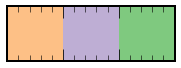

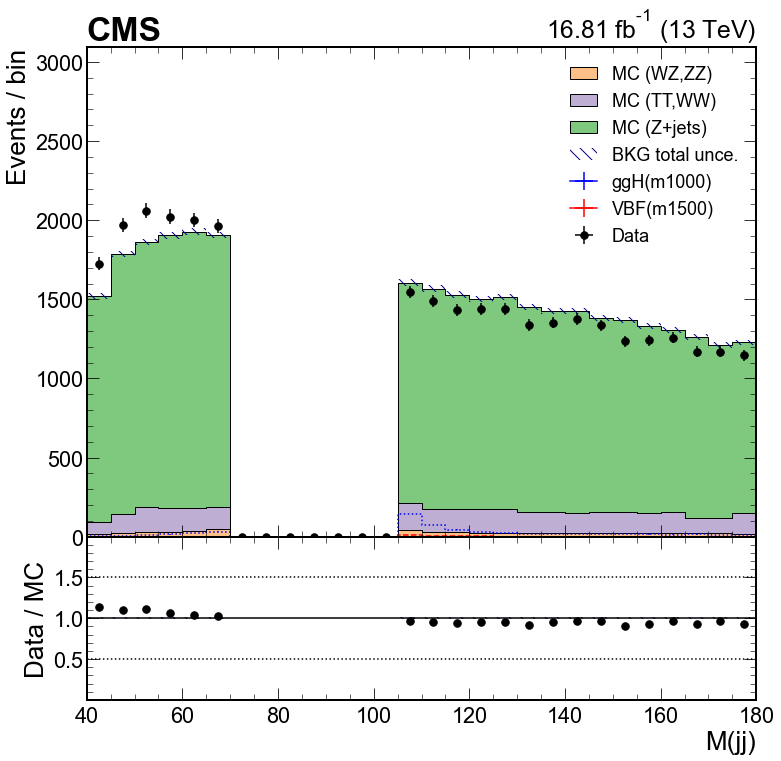

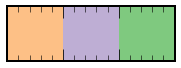

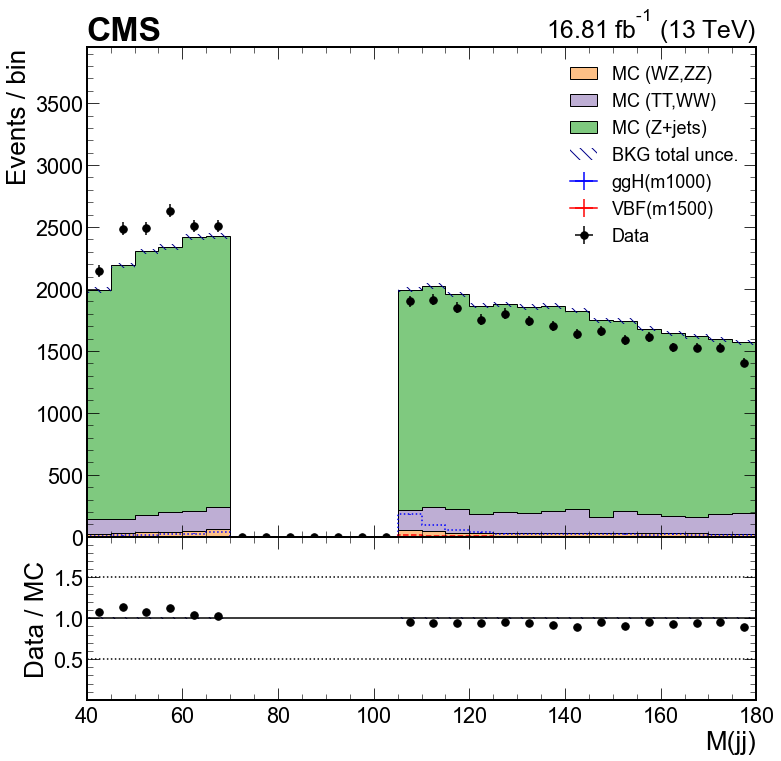

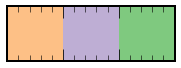

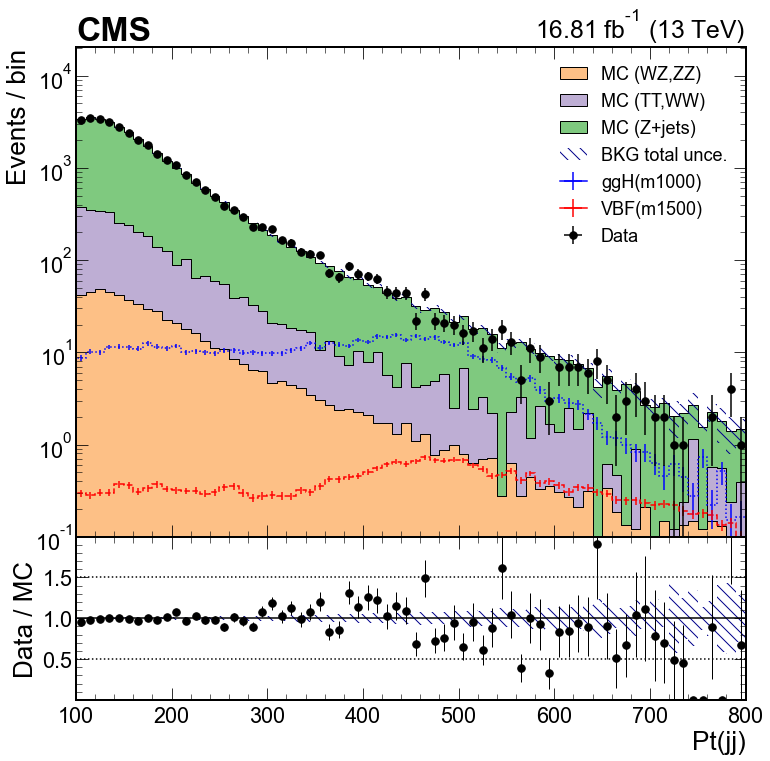

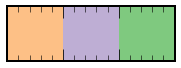

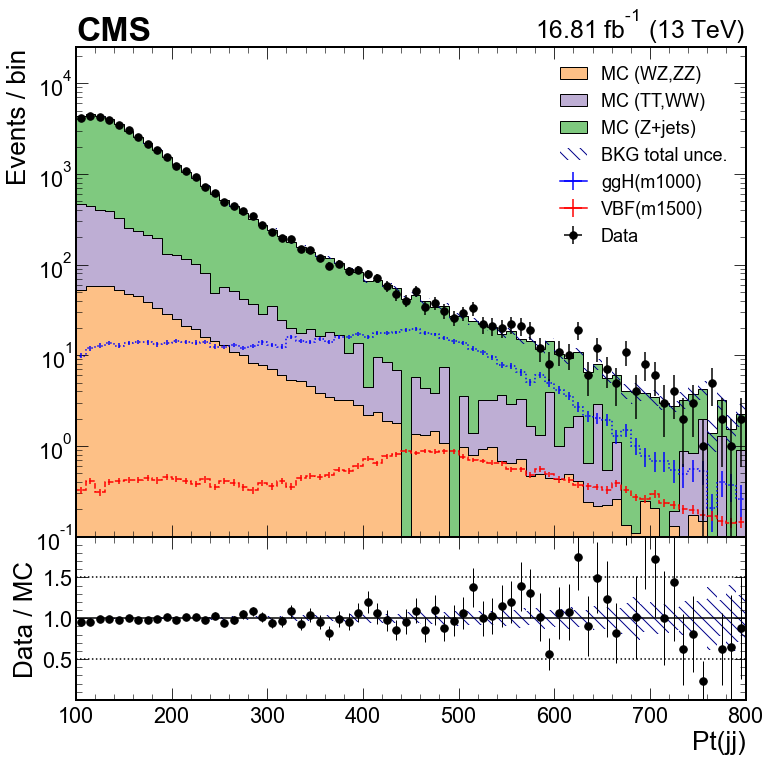

In [46]:
####======================================Draw lists of  varbs============================================
####======================================And save plots================================================
#set draw var
#varbs = ['pt2l','mass2l','particleNetZvsQCD','massmerged','ptmerged']
varbs = ['mass2jet','pt2jet']
for var in varbs:
    print(f"[INFO] it is {var} plot")
    nbins, xmin, xmax = bininfo[var][0], bininfo[var][1], bininfo[var][2]
    edge = np.linspace(xmin, xmax, nbins+1)
    if var.find('pt')!=-1 or var.find('massmerged')!=-1 :
        islogY = True
    else:
        islogY = False
        
    #fill histo 
    bkg_hists = {}; Data_hist = {}; signal_hists = {}
    for cat in cats:
        bkg_hists[cat] = [None,None,None]; Data_hist[cat] = None; signal_hists[cat] = []
        for sample in Samples_lists:
            #print(f"This is {sample} in {cat}")
            if sample!='Data':
                temp_array = bkg_array_cut[cat][sample]
                weights = (temp_array['EventWeight']*lumi[2016]*1000*samples_inf[sample][1])/sumWeight[sample]
                temp_hist = get_hist(temp_array[var],weights,nbins,xmin,xmax)
            
                if sample.find('DY')!=-1:
                    if (bkg_hists[cat])[2]==None:
                        (bkg_hists[cat])[2] = temp_hist
                    else:
                        (bkg_hists[cat])[2]+=temp_hist
                if sample.find('TTJets')!=-1 or sample.find('WWTo2L2Nu')!=-1:
                    if (bkg_hists[cat])[1]==None:
                        (bkg_hists[cat])[1] = temp_hist
                    else:
                        (bkg_hists[cat])[1]+=temp_hist
                if sample.find('WZTo2Q2L')!=-1 or sample.find('ZZTo2Q2L')!=-1:
                    if (bkg_hists[cat])[0]==None:
                        (bkg_hists[cat])[0] = temp_hist
                    else:
                        (bkg_hists[cat])[0]+=temp_hist
            else:
                temp_array = data_array_cut[cat]
                weights = np.ones_like(temp_array['EventWeight'])
                Data_hist[cat] = get_hist(temp_array[var],weights,nbins,xmin,xmax)
        
        for sample in signal_lists:
            temp_array = signal_array_cut[cat][sample]
            weights = (temp_array['EventWeight']*lumi[2016]*samples_inf[sample][1]*100)/sumWeight[sample] #scale 100
            temp_hist = get_hist(temp_array[var],weights,nbins,xmin,xmax)
            signal_hists[cat].append(temp_hist)
    
    print(f"Fill done {var}")

    #draw var
    for cat in cats:
        print(f"[INFO] it is {cat} plot")
        plot_unce = True
        set_sns_color(color_order_bkg)
        f = plt.figure(figsize=(12,12))
        gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0)
        ##================================ Upper histogram panel=========================================
        ax = f.add_subplot(gs[0])
        hep.cms.label(data=True, year=year, ax=ax, rlabel=r'%s $fb^{-1}$ (13 TeV)'%lumi[year], fontname='sans-serif')
        ax.set_xlim(xmin, xmax); ax.set_xticklabels([]); ax.set_ylabel('Events / bin', ha='right', y=1.0)
    
        ##BACKGRUND
        #hep.histplot(bkg_hists[cat],label=[f'MC ({var})' for var in ['WZ,ZZ','TT,WW','Z+jets']],histtype='fill', edgecolor='k', linewidth=1, stack=True) ## draw MC
        plot_hist(bkg_hists[cat],label=[f'MC ({var})' for var in ['WZ,ZZ','TT,WW','Z+jets']],histtype='fill', edgecolor='k', linewidth=1, stack=True) ## draw MC
        bkg_hist = bkg_hists[cat][0]+bkg_hists[cat][1]+bkg_hists[cat][2]
        bkg_tot = bkg_hist.values()
        bkg_err = get_err(bkg_hist)
        #bkg_err = np.sqrt(bkg_hist.view(flow=False).variance)

        if plot_unce:
            #ax.fill_between(edge, (bkg_tot-bkg_err).tolist()+[0], (bkg_tot+bkg_err).tolist()+[0], label='BKG total unce.', step='post', hatch='\\\\', edgecolor='dimgrey', facecolor='none', linewidth=0) ## draw bkg unce. 
            ax.fill_between(edge, (bkg_tot-bkg_err).tolist()+[0], (bkg_tot+bkg_err).tolist()+[0], label='BKG total unce.', step='post', hatch='\\\\', edgecolor='darkblue', facecolor='none', linewidth=0) ## draw bkg unce.
        ax.set_xlim(xmin, xmax); ax.set_xticklabels([]);
        ax.set_ylabel('Events / bin', ha='right', y=1.0);
    
        ##SIGNAL
        colors = ['blue', 'red']
        plot_hist(signal_hists[cat],label=[ var for var in ['ggH(m1000)','VBF(m1500)']],linestyle=[style for style in [':','--']], color=[color for color in colors])
    
        ##DATA
        data_err = get_err(Data_hist[cat])
        data = Data_hist[cat].values()
        #hep.histplot(Data_hist[cat], yerr=data_err,label='Data', histtype='errorbar', color='k', markersize=15, elinewidth=1.5) ## draw data
        plot_hist(Data_hist[cat],label='Data', histtype='errorbar', color='k', markersize=15, elinewidth=1.5) ## draw data
        if islogY:
            ax.set(yscale = "log")
            ax.set_ylim(1e-1, 3*ax.get_ylim()[1])
        else:
            ax.set_ylim(0, ax.get_ylim()[1])
            ax.set_ylim(0, 1.5*max(data))
        hep.plot.yscale_legend
        ax.legend(fontsize=18)

        ##==========================================Ratio panel========================
        ax1 = f.add_subplot(gs[1]); ax1.set_xlim(xmin, xmax); ax1.set_ylim(0.001, 1.999)
        ax1.set_xlabel(bininfo[var][3], ha='right', x=1.0); ax1.set_ylabel('Data / MC', ha='center')
        ax1.plot([xmin,xmax], [1,1], 'k'); ax1.plot([xmin,xmax], [0.5,0.5], 'k:'); ax1.plot([xmin,xmax], [1.5,1.5], 'k:')
    
        ratio=np.nan_to_num((data/bkg_tot),nan=-1)
        ratio_err = np.nan_to_num((data_err/bkg_tot),nan=-1)
        hep.histplot(ratio, yerr = ratio_err,bins=edge, histtype='errorbar', color='k', markersize=15, elinewidth=1)
        #hep.histplot(data/bkg_tot, yerr = data_err/bkg_err,bins=edge, histtype='errorbar', color='k', markersize=15, elinewidth=1)
        if plot_unce:
            ratio_unc_low = np.nan_to_num(((bkg_tot-bkg_err)/bkg_tot),nan=-1)
            ratio_unc_up = np.nan_to_num(((bkg_tot+bkg_err)/bkg_tot),nan=-1)
            ax1.fill_between(edge, ratio_unc_low.tolist()+[0],ratio_unc_up.tolist()+[0], step='post', hatch='\\\\', edgecolor='darkblue', facecolor='none', linewidth=0) ## draw bkg unce.
            #ax1.fill_between(edge, ((bkg_tot-bkg_err)/bkg_tot).tolist()+[0], ((bkg_tot+bkg_err)/bkg_tot).tolist()+[0], step='post', hatch='\\\\', edgecolor='darkblue', facecolor='none', linewidth=0) ## draw bkg unce.

In [39]:
for cat in cats:
    print(f"[INFO] it is {cat} plot")
    plot_unce = True
    set_sns_color(color_order_bkg)
    f = plt.figure(figsize=(12,12))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0)
    
    ## Upper histogram panel
    ax = f.add_subplot(gs[0])
    hep.cms.label(data=True, year=year, ax=ax, rlabel=r'%s $fb^{-1}$ (13 TeV)'%lumi[year], fontname='sans-serif')
    ax.set_xlim(xmin, xmax); ax.set_xticklabels([]);
    ax.set_ylabel('Events / bin', ha='right', y=1.0)
    #content = hist.values()
    hep.cms.label(data=True, year=year, ax=ax, rlabel=r'%s $fb^{-1}$ (13 TeV)'%lumi[year], fontname='sans-serif')
    #hep.histplot(content, bins=edge, label="MC",histtype='fill', edgecolor='k', linewidth=1, stack=True) ## draw MC
    hep.histplot(bkg_hists[cat],label=[f'MC ({var})' for var in ['WZ,ZZ','TT,WW','Z+jets']],histtype='fill', edgecolor='k', linewidth=1, stack=True) ## draw MC
    bkg_hist = bkg_hists[cat][0]+bkg_hists[cat][1]+bkg_hists[cat][2]
    bkg_tot = bkg_hist.values()
    #bkg_err = get_err(bkg_hist)
    bkg_err = np.sqrt(bkg_hist.view(flow=False).variance)
    edge = (Data_hist[cat].axes.edges)[0]
    if plot_unce:
        #ax.fill_between(edge, (bkg_tot-bkg_err).tolist()+[0], (bkg_tot+bkg_err).tolist()+[0], label='BKG total unce.', step='post', hatch='\\\\', edgecolor='dimgrey', facecolor='none', linewidth=0) ## draw bkg unce. 
        ax.fill_between(edge, (bkg_tot-bkg_err).tolist()+[0], (bkg_tot+bkg_err).tolist()+[0], label='BKG total unce.', step='post', hatch='\\\\', edgecolor='darkblue', facecolor='none', linewidth=0) ## draw bkg unce.
    ax.set_xlim(xmin, xmax); ax.set_xticklabels([]);
    ax.set_ylabel('Events / bin', ha='right', y=1.0);

    #data, data_errh, data_errl = Data_hist.yvalues, Data_hist.yerrorshigh, Data_hist.yerrorslow
    data_err = get_err(Data_hist[cat])
    data = Data_hist[cat].values()
    hep.histplot(Data_hist[cat], yerr=data_err,label='Data', histtype='errorbar', color='k', markersize=15, elinewidth=1.5) ## draw data
    ax.set_ylim(0, ax.get_ylim()[1])
    ax.set_ylim(0, 1.5*max(data))
    #ax.set(yscale = "log")
    ax.legend(fontsize=12)

    ## Ratio panel
    ax1 = f.add_subplot(gs[1]); ax1.set_xlim(xmin, xmax); ax1.set_ylim(0.001, 1.999)
    ax1.set_xlabel(bininfo[var][3], ha='right', x=1.0); ax1.set_ylabel('Data / MC', ha='center')
    ax1.plot([xmin,xmax], [1,1], 'k'); ax1.plot([xmin,xmax], [0.5,0.5], 'k:'); ax1.plot([xmin,xmax], [1.5,1.5], 'k:')
    
    #ratio = replace_nan(data/bkg_tot,isunc = False)
    #ratio_err = replace_nan(data_err/bkg_tot,isunc = False)
    ratio=np.nan_to_num((data/bkg_tot),nan=0)
    ratio_err = np.nan_to_num((data_err/bkg_tot),nan=0)
    hep.histplot(ratio, yerr = ratio_err,bins=edge, histtype='errorbar', color='k', markersize=15, elinewidth=1)
    #hep.histplot(data/bkg_tot, yerr = data_err/bkg_tot,bins=edge, histtype='fill', linewidth=1)
    #ax1.fill_between(edge, (data/bkg_tot-bkg_err).tolist()+[0], (data/bkg_tot+bkg_err).tolist()+[0], step = "pre",facecolor='none', linewidth=0) ## draw bkg unce.
    #hep.histplot(data/bkg_tot, yerr = data_err/bkg_tot,bins=edge, color='k')
    if plot_unce:
        ratio_unc_low =replace_nan(((bkg_tot-bkg_err)/bkg_tot),isunc = True)
        ratio_unc_up = replace_nan(((bkg_tot+bkg_err)/bkg_tot),isunc = True)
        ratio_unc_low = 
        ax1.fill_between(edge, ratio_unc_low.tolist()+[0],ratio_unc_up.tolist()+[0], step='post', hatch='\\\\', edgecolor='darkblue', facecolor='none', linewidth=0) ## draw bkg unce.


SyntaxError: invalid syntax (2149737806.py, line 53)

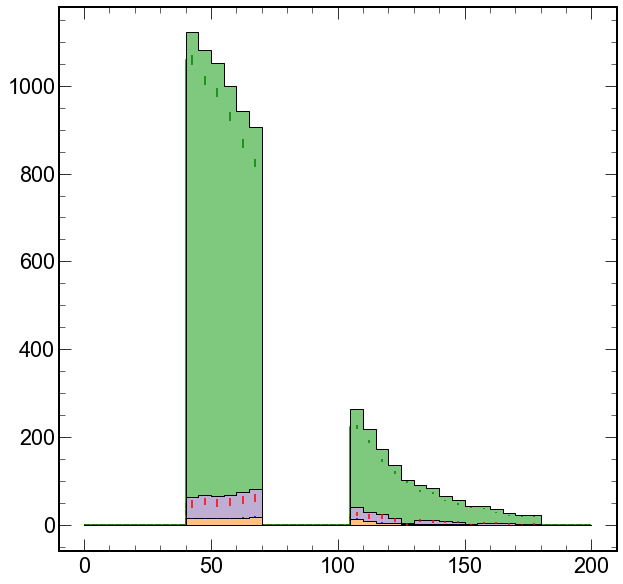

In [28]:
colors = ['blue', 'red', 'green']
plot_hist(bkg_hists[cat],label=[f'MC ({var})' for var in ['WZ,ZZ','TT,WW','Z+jets']],linestyle=[style for style in [':','--']], color=[color for color in colors])
plot_hist(bkg_hists[cat],label=[f'MC ({var})' for var in ['WZ,ZZ','TT,WW','Z+jets']],histtype='fill', edgecolor='k', linewidth=1, stack=True)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f61b7b8f190>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

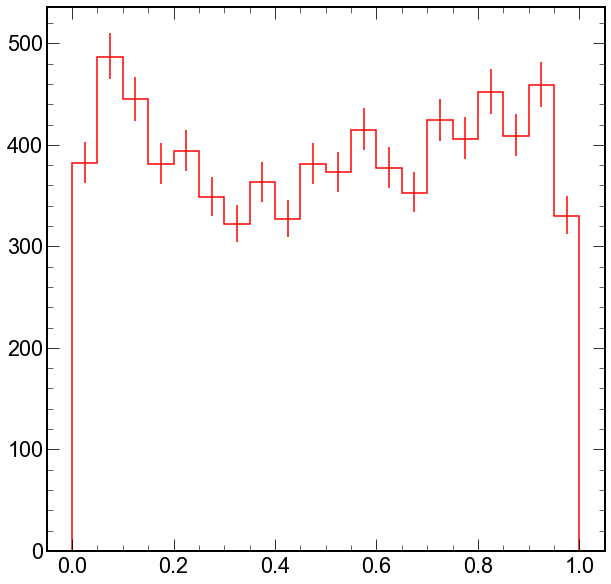

In [286]:
hep.histplot(Data_hist[cat],label='Data', histtype='step', color='r',linewidth=1.5) ## draw data

In [280]:
sns.color_palette('Accent',7)

[(0.4980392156862745, 0.788235294117647, 0.4980392156862745),
 (0.7450980392156863, 0.6823529411764706, 0.8313725490196079),
 (0.9921568627450981, 0.7529411764705882, 0.5254901960784314),
 (1.0, 1.0, 0.6),
 (0.2196078431372549, 0.4235294117647059, 0.6901960784313725),
 (0.9411764705882353, 0.00784313725490196, 0.4980392156862745),
 (0.7490196078431373, 0.3568627450980392, 0.09019607843137253)]

In [11]:
def plot_hist(hists, normed=False, **kwargs):
    r"""Plot the histogram in the type of boost_histogram
    """
    
    if not isinstance(hists, (list, tuple)):
        hists = [hists]
    content = [h.view(flow=False).value for h in hists]
    bins = hists[0].axes[0].edges
    if 'bins' in kwargs:
        bins = kwargs.pop('bins')
    if 'yerr' in kwargs:
        yerr = kwargs.pop('yerr')
    else:
        yerr = [np.sqrt(h.view(flow=False).variance) for h in hists]
    if normed:
        for i in range(len(content)):
            contsum = sum(content[i])
            content[i] /= contsum
            yerr[i] /= contsum
    if len(hists) == 1:
        content, yerr = content[0], yerr[0]
    hep.histplot(content, bins=bins, yerr=yerr, **kwargs)

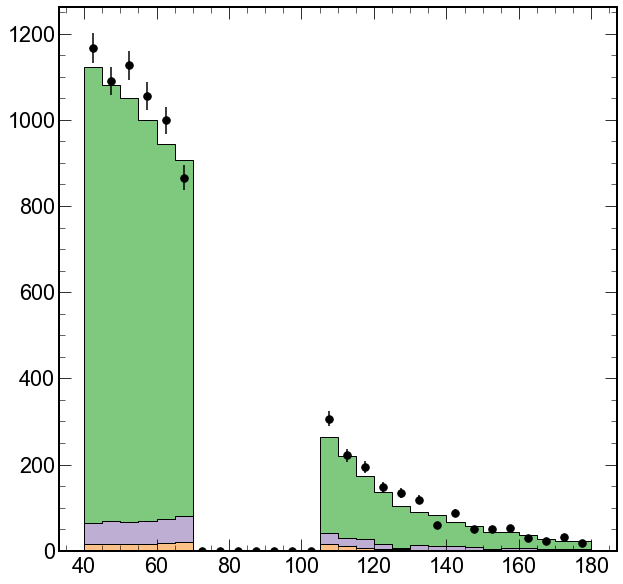

In [311]:
plot_hist(bkg_hists[cat], bins=edge,label=[f'MC ({var})' for var in ['WZ,ZZ','TT,WW','Z+jets']], histtype='fill', edgecolor='k', linewidth=1, stack=True)
plot_hist(Data_hist[cat], bins=edge, label='Data', histtype='errorbar', color='k', markersize=15, elinewidth=1.5)

In [32]:
arr  = np.array([1,2,34,5])
arr

array([ 1,  2, 34,  5])

In [33]:
arr_one = np.ones_like(arr)
arr_one

array([1, 1, 1, 1])

In [34]:
uproot

'isEE'